In [335]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

In [336]:
data = pd.read_csv('sleepdata_2.csv', sep=';')

In [337]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Start                        921 non-null    object 
 1   End                          921 non-null    object 
 2   Sleep Quality                921 non-null    object 
 3   Regularity                   921 non-null    object 
 4   Mood                         0 non-null      float64
 5   Heart rate (bpm)             921 non-null    int64  
 6   Steps                        921 non-null    int64  
 7   Alarm mode                   921 non-null    object 
 8   Air Pressure (Pa)            492 non-null    float64
 9   City                         487 non-null    object 
 10  Movements per hour           921 non-null    float64
 11  Time in bed (seconds)        921 non-null    float64
 12  Time asleep (seconds)        921 non-null    float64
 13  Time before sleep (s

In [338]:
data.describe()

,Mood,Heart rate (bpm),Steps,Air Pressure (Pa),Movements per hour,Time in bed (seconds),Time asleep (seconds),Time before sleep (seconds),Snore time,Weather temperature (°C)
count,0.0,921.0,921.000000,492.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000
mean,NaN,0.0,5311.599349,68.660163,174.277416,27505.497611,23912.683170,1001.556135,312.944300,2.142562
std,NaN,0.0,4396.822762,41.845368,822.776299,3916.696288,4066.189356,1046.287777,455.472848,6.324558
min,NaN,0.0,0.000000,0.000000,0.000000,1852.800000,0.000000,0.000000,0.000000,-19.000000
25%,NaN,0.0,2299.000000,0.000000,37.000000,25500.600000,21627.500000,449.900000,0.000000,0.000000
50%,NaN,0.0,4245.000000,93.700000,49.600000,27422.900000,23919.000000,563.700000,148.000000,0.000000
75%,NaN,0.0,7452.000000,94.400000,65.200000,29530.100000,26257.000000,1287.000000,440.000000,3.100000
max,NaN,0.0,38165.000000,96.500000,17926.700000,46703.400000,45769.400000,5677.700000,4477.300000,24.500000


In [339]:
data = data.drop(['Mood', 'Heart rate (bpm)', 'City', 'Notes', 'Weather type'], axis=1)

In [340]:
data['Start'] = pd.to_datetime(data['Start'])
data['End'] = pd.to_datetime(data['End'])
data['Window start'] = pd.to_datetime(data['Window start'])
data['Window stop'] = pd.to_datetime(data['Window stop'])

data['Sleep Quality'] = data['Sleep Quality'].str.replace('%', '').astype(int)
data['Regularity'] = data['Regularity'].str.replace('%', '').astype(int)

data.loc[data['Alarm mode'] == 'Normal', 'Alarm mode'] = 1
data.loc[data['Alarm mode'] == 'No alarm', 'Alarm mode'] = 0

data['Time in bed (seconds)'] = data['Time in bed (seconds)'] / 3600
data['Time asleep (seconds)'] = data['Time asleep (seconds)'] / 3600 
data['Time before sleep (seconds)'] = data['Time before sleep (seconds)'] / 60 

data.loc[data['Snore time'] == 0, 'Did snore'] = False
data['Did snore'] = data['Did snore'].astype(int)
data['Snore time'] = data['Snore time'] / 60

pressure = data.loc[(data['Air Pressure (Pa)'] != 0) & (data['Air Pressure (Pa)'].notna())]['Air Pressure (Pa)'].mean()
data.loc[data['Air Pressure (Pa)'].isna(), 'Air Pressure (Pa)'] = pressure
data.loc[data['Air Pressure (Pa)'] == 0, 'Air Pressure (Pa)'] = pressure

data = data.rename(columns={'Regularity':'Regularity(%)', 'Sleep Quality':'Sleep Quality(%)',
                           'Time in bed (seconds)':'Time in bed (hours)', 'Time asleep (seconds)':'Time asleep (hours)',
                            'Time before sleep (seconds)':'Time before sleep (minutes)', 'Snore time':'Snore time(minutes)'})

In [341]:
data[data['Window stop'] != data['Window start']]['Window start'].value_counts()

2019-07-03 05:20:00    1
2019-07-07 07:00:00    1
2019-07-09 05:30:00    1
2021-05-09 06:30:00    1
2021-05-10 05:00:00    1
Name: Window start, dtype: int64

In [342]:
data = data.drop(['Window start', 'Window stop'], axis=1)

In [343]:
data

,Start,End,Sleep Quality(%),Regularity(%),Steps,Alarm mode,Air Pressure (Pa),Movements per hour,Time in bed (hours),Time asleep (hours),Time before sleep (minutes),Did snore,Snore time(minutes),Weather temperature (°C)
0,2019-05-12 23:26:13,2019-05-13 06:11:03,60,0,8350,1,94.096936,35.0,6.747000,6.387167,2.698333,1,1.533333,0.0
1,2019-05-13 22:10:31,2019-05-14 06:10:42,73,0,4746,1,94.096936,78.6,8.002833,6.989139,3.201667,0,0.000000,0.0
2,2019-05-14 21:43:00,2019-05-15 06:10:41,86,96,4007,1,94.096936,60.5,8.461528,7.897444,3.385000,1,1.233333,0.0
3,2019-05-15 23:11:51,2019-05-16 06:13:59,77,92,6578,1,94.096936,45.2,7.035444,6.425694,2.815000,0,0.000000,0.0
4,2019-05-16 23:12:13,2019-05-17 06:20:32,78,94,4913,1,94.096936,44.6,7.138444,6.281833,2.855000,1,3.133333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2022-03-24 21:33:46,2022-03-25 04:21:40,71,77,3903,1,95.200000,39.7,6.798361,5.778611,8.158333,1,11.595000,4.0
917,2022-03-25 16:48:05,2022-03-25 17:30:22,9,14,495,1,83.800000,0.0,0.704500,0.000000,0.000000,0,0.000000,5.0
918,2022-03-26 21:14:23,2022-03-27 06:11:01,49,-1,13388,1,83.500000,82.7,8.943917,6.827194,60.818333,1,8.440000,-1.1
919,2022-03-28 22:53:23,2022-03-29 04:50:36,77,22,456,1,93.900000,17.3,5.953778,4.405778,7.145000,1,1.000000,6.1


# Проверка аномалий по Граббсу

In [344]:
import numpy as np
from outliers import smirnov_grubbs as grubbs

for item in data.drop(['Start', 'End'], axis=1).columns:
    print(f'{item}: ', len(grubbs.test(np.array(data[item]), alpha=.05)))

Sleep Quality(%):  913
Regularity(%):  901
Steps:  905
Alarm mode:  921
Air Pressure (Pa):  915
Movements per hour:  877
Time in bed (hours):  911
Time asleep (hours):  912
Time before sleep (minutes):  920
Did snore:  921
Snore time(minutes):  901
Weather temperature (°C):  921


# Проверка на мультиколлинеарность

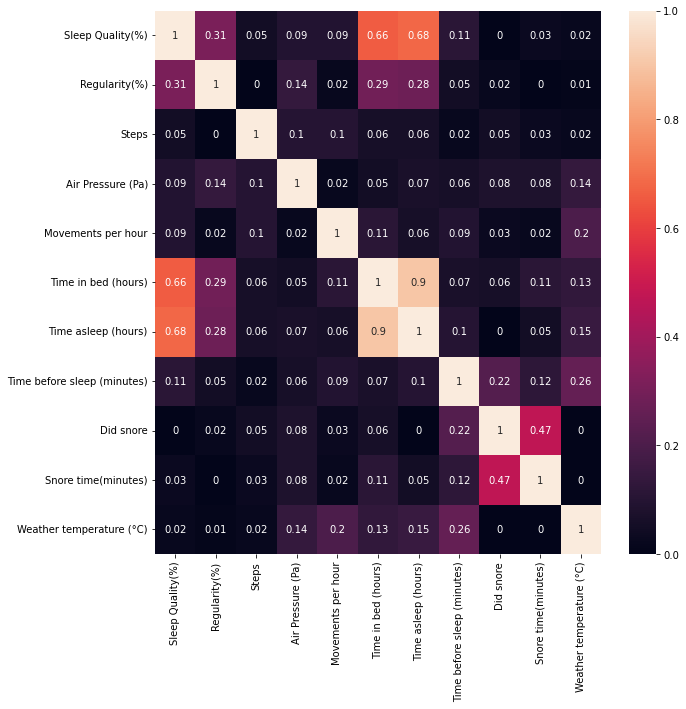

In [345]:
ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(round(abs(data.corr()), 2), annot=True)

In [346]:
data = data.drop(['Time in bed (hours)', 'Did snore', 'Weather temperature (°C)','Steps', 'Air Pressure (Pa)', 'Regularity(%)'], axis=1)

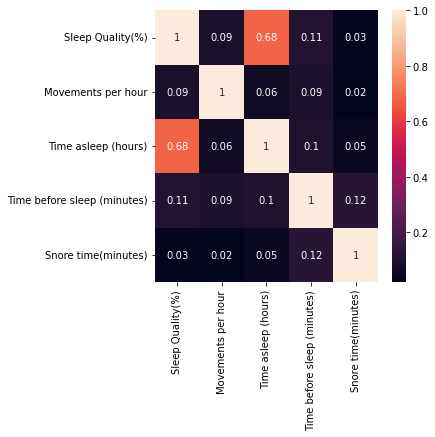

In [347]:
ax = plt.subplots(figsize=(5,5)) 
ax = sns.heatmap(round(abs(data.corr()), 2), annot=True)

In [349]:
data.drop(['Start', 'End'], axis=1).to_excel('sleep.xlsx', engine='xlsxwriter')

# Построение регрессии 

In [247]:
import statsmodels.api as sm
import numpy as np

In [248]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Sleep Quality(%)', 'Start', 'End'], axis=1), data['Sleep Quality(%)'], test_size=0.1, random_state=0)

In [249]:
X_train = np.asarray(X_train, dtype=float).transpose()
y_train = np.asarray(y_train, dtype=float)

In [250]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

print(reg_m(y_train, X_train).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     298.3
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          4.41e-131
Time:                        18:59:25   Log-Likelihood:                -2968.6
No. Observations:                 828   AIC:                             5945.
Df Residuals:                     824   BIC:                             5964.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1290      0.017      7.421      0.0

In [43]:
logreg = LogisticRegression()

In [252]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Sleep Quality(%)', 'Start', 'End'], axis=1), data['Sleep Quality(%)'], test_size=0.2, random_state=0)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [255]:
from sklearn.metrics import mean_absolute_error

In [256]:
(f'Average approximation error: {round(100*(mean_absolute_error(y_test, y_pred) / y_test.abs().sum()), 2)} %')

'Average approximation error: 0.07 %'

# Парная нелинейная регрессия

D:\anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


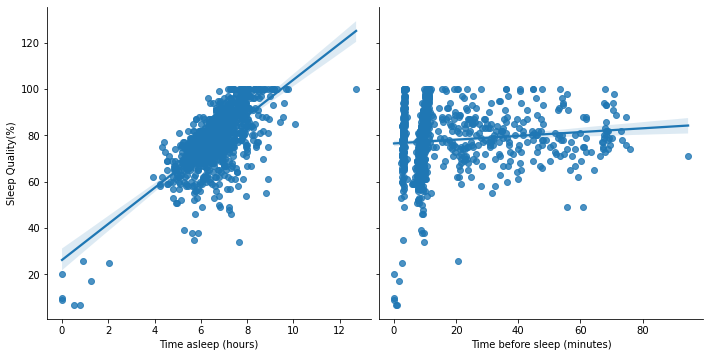

In [259]:
sns.pairplot(
    data.drop(['Start', 'End'], axis=1),
    y_vars='Sleep Quality(%)',
    x_vars=['Time asleep (hours)', 'Time before sleep (minutes)'],
    size=5,
    kind='reg',
    diag_kind=None
)

In [299]:
import numpy as np

fit = np.polyfit (data['Time asleep (hours)'], np.log (data['Sleep Quality(%)']), 1)
print(fit)

[0.13859252 3.41509513]


In [300]:
new_df = data[['Time asleep (hours)','Sleep Quality(%)']]
new_df['Sleep Quality(%)'] = np.log(data['Sleep Quality(%)'])
new_df['predict'] = new_df['Time asleep (hours)']*0.13859252 + 3.41509513

C:\Users\user\AppData\Local\Temp\ipykernel_11424\758925769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Sleep Quality(%)'] = np.log(data['Sleep Quality(%)'])
C:\Users\user\AppData\Local\Temp\ipykernel_11424\758925769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['predict'] = new_df['Time asleep (hours)']*0.13859252 + 3.41509513


In [301]:
y_test = new_df['Sleep Quality(%)']
y_pred = new_df['predict']

In [302]:
(f'Average approximation error: {round(100*(mean_absolute_error(y_test, y_pred) / y_test.abs().sum()), 4)} %')

'Average approximation error: 0.0027 %'

In [303]:
new_df = data[['Time asleep (hours)','Sleep Quality(%)']]
new_df['predict'] = np.exp(new_df['Time asleep (hours)']*0.13859252 + 3.41509513)

C:\Users\user\AppData\Local\Temp\ipykernel_11424\2705646993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['predict'] = np.exp(new_df['Time asleep (hours)']*0.13859252 + 3.41509513)


In [304]:
y_test = new_df['Sleep Quality(%)']
y_pred = new_df['predict']

In [305]:
(f'Average approximation error: {round(100*(mean_absolute_error(y_test, y_pred) / y_test.abs().sum()), 4)} %')

'Average approximation error: 0.011 %'

D:\anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


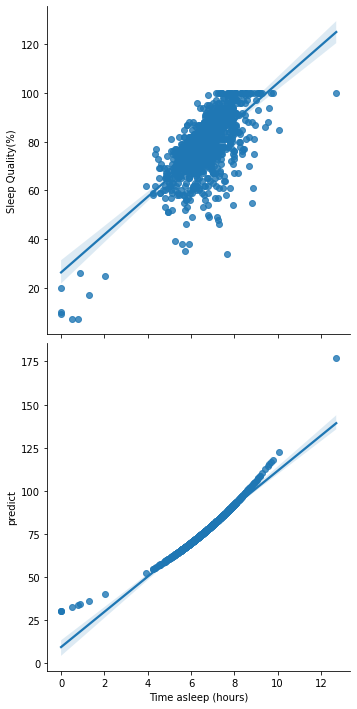

In [306]:
sns.pairplot(
    new_df,
    y_vars=['Sleep Quality(%)', 'predict'],
    x_vars='Time asleep (hours)',
    size=5,
    kind='reg',
    diag_kind=None
)

In [307]:
import numpy as np

fit = np.polyfit (data['Time asleep (hours)'], np.exp(data['Sleep Quality(%)']), 1)
print(fit)

[ 1.59912052e+42 -9.42399331e+42]


In [308]:
new_df = data[['Time asleep (hours)','Sleep Quality(%)']]
new_df['Sleep Quality(%)'] = np.exp(data['Sleep Quality(%)'])
new_df['predict'] = new_df['Time asleep (hours)']*1.59912052e+42 - 9.42399331e+42

C:\Users\user\AppData\Local\Temp\ipykernel_11424\1329622539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Sleep Quality(%)'] = np.exp(data['Sleep Quality(%)'])
C:\Users\user\AppData\Local\Temp\ipykernel_11424\1329622539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['predict'] = new_df['Time asleep (hours)']*1.59912052e+42 - 9.42399331e+42


In [309]:
y_test = new_df['Sleep Quality(%)']
y_pred = new_df['predict']

In [310]:
(f'Average approximation error: {round(100*(mean_absolute_error(y_test, y_pred) / y_test.abs().sum()), 4)} %')

'Average approximation error: 0.2185 %'

In [312]:
import numpy as np

fit = np.polyfit (data['Time asleep (hours)'], 1/(data['Sleep Quality(%)']), 1)
print(fit)

[-0.00387596  0.03943409]


In [313]:
new_df = data[['Time asleep (hours)','Sleep Quality(%)']]
new_df['Sleep Quality(%)'] = np.exp(data['Sleep Quality(%)'])
new_df['predict'] = new_df['Time asleep (hours)']*(-0.00387596) + 0.03943409

C:\Users\user\AppData\Local\Temp\ipykernel_11424\1620837498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Sleep Quality(%)'] = np.exp(data['Sleep Quality(%)'])
C:\Users\user\AppData\Local\Temp\ipykernel_11424\1620837498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['predict'] = new_df['Time asleep (hours)']*(-0.00387596) + 0.03943409


In [314]:
y_test = new_df['Sleep Quality(%)']
y_pred = new_df['predict']

In [315]:
(f'Average approximation error: {round(100*(mean_absolute_error(y_test, y_pred) / y_test.abs().sum()), 4)} %')

'Average approximation error: 0.1086 %'